In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import joblib

# Define custom scorer for MAPE
def mape_scorer(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Load the dataset
df_raw = pd.read_csv('../Train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)
df_raw.set_index('date_time', inplace=True)

# Extract hour from the 'date_time' column
df_raw['hour'] = df_raw.index.hour

# One-hot encode categorical features
df = pd.get_dummies(df_raw, columns=['is_holiday', 'weather_type', 'weather_description'], drop_first=True)

# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Remove rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Split the dataset into features and the target
X = df.drop(target, axis=1)
y = df[target]

# Split the data into train and test sets
total_samples = df.shape[0]
split_index = int(total_samples * 0.9)

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

# Scale the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVR regressor
svr_model = SVR()

# Train the model on the scaled data
svr_model.fit(X_train_scaled, y_train)

# Save the trained model
joblib.dump(svr_model, 'svr_model_default_parameters.joblib')

# Evaluate metrics on the training set
y_train_pred = svr_model.predict(X_train_scaled)
train_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'MSE': mean_squared_error(y_train, y_train_pred),
    'MAE': mean_absolute_error(y_train, y_train_pred),
    'MAPE': mape_scorer(y_train, y_train_pred)
}

# Evaluate metrics on the validation set
y_val_pred = svr_model.predict(X_test_scaled)
val_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_val_pred)),
    'MSE': mean_squared_error(y_test, y_val_pred),
    'MAE': mean_absolute_error(y_test, y_val_pred),
    'MAPE': mape_scorer(y_test, y_val_pred)
}

# Print and compare metrics
print("Training Set Metrics:")
print(train_metrics)

print("\nValidation Set Metrics:")
print(val_metrics)

Training Set Metrics:
{'RMSE': 1535.6185274243453, 'MSE': 2358124.2617689148, 'MAE': 1322.742647814425, 'MAPE': 270.18705527256276}

Validation Set Metrics:
{'RMSE': 1546.5544417690187, 'MSE': 2391830.641355481, 'MAE': 1335.3941117989168, 'MAPE': 123.53198066855269}


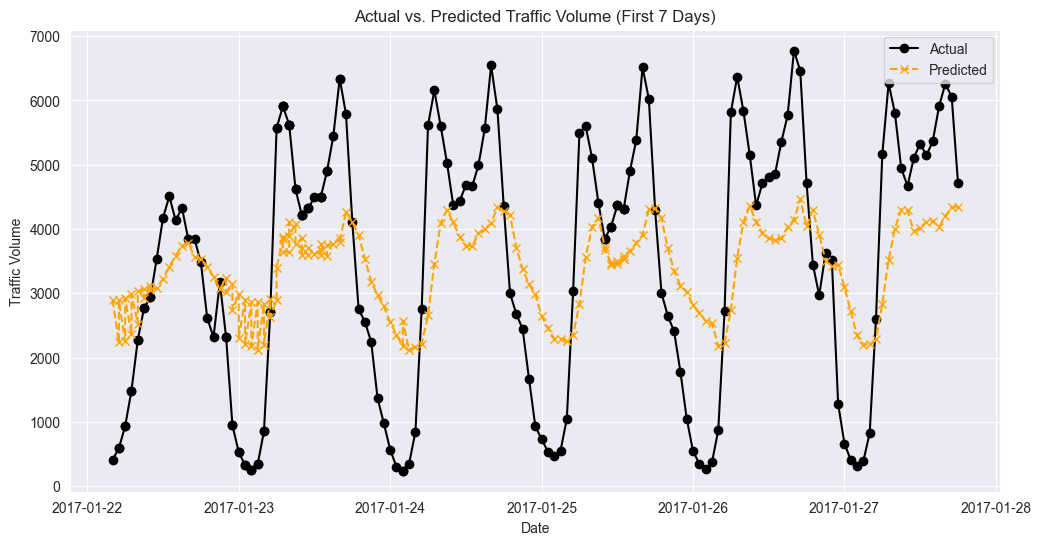

In [5]:
# Plot the actual vs. predicted traffic volume for the first 7 days
plt.figure(figsize=(12, 6))
plt.plot(y_test.index[:168], y_test.iloc[:168], label='Actual', marker='o', linestyle='-', color='black')
plt.plot(y_test.index[:168], y_val_pred[:168], label='Predicted', marker='x', linestyle='--', color='orange')
plt.title('Actual vs. Predicted Traffic Volume (First 7 Days)')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()